In [45]:
# !python -m spacy download en_core_web_md
# !pip install scikit-plot
# !pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import random

import spacy
import en_core_web_md
import nltk
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
df = pd.read_csv('/content/drive/MyDrive/df_klasyfikacja_shared_march.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4122 non-null   int64  
 1   section           4122 non-null   object 
 2   byline            3929 non-null   object 
 3   title             4122 non-null   object 
 4   abstract          4118 non-null   object 
 5   class             4122 non-null   object 
 6   print_page        2448 non-null   float64
 7   pub_date          3983 non-null   object 
 8   type_of_material  3983 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 290.0+ KB


# Data Cleaning

In [5]:
df = df.dropna(subset = ['title', 'abstract', 'byline'])

In [6]:
df.drop_duplicates(subset=['title', 'abstract'], inplace=True) 

In [7]:
df = df.reset_index()

In [8]:
df.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [9]:
df['byline'] = df['byline'].apply(lambda x: x[3:])  

In [10]:
df['print_page'] = df['print_page'].fillna(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   section           3899 non-null   object 
 1   byline            3899 non-null   object 
 2   title             3899 non-null   object 
 3   abstract          3899 non-null   object 
 4   class             3899 non-null   object 
 5   print_page        3899 non-null   float64
 6   pub_date          3761 non-null   object 
 7   type_of_material  3761 non-null   object 
dtypes: float64(1), object(7)
memory usage: 243.8+ KB


Limit the number of observations belonging to the 'all' class to 1000 to make the set more balanced

In [12]:
df[df['class']=='all'].index

Int64Index([ 210,  211,  212,  213,  214,  215,  216,  217,  218,  219,
            ...
            3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898],
           dtype='int64', length=3689)

In [13]:
random.seed(1)
a = random.sample(range(210, 3898), 1000)

In [14]:
df = pd.concat([df[df['class']=='top'],df.loc[a]])

# Feature Engineering

Text(0, 0.5, 'Number of articles')

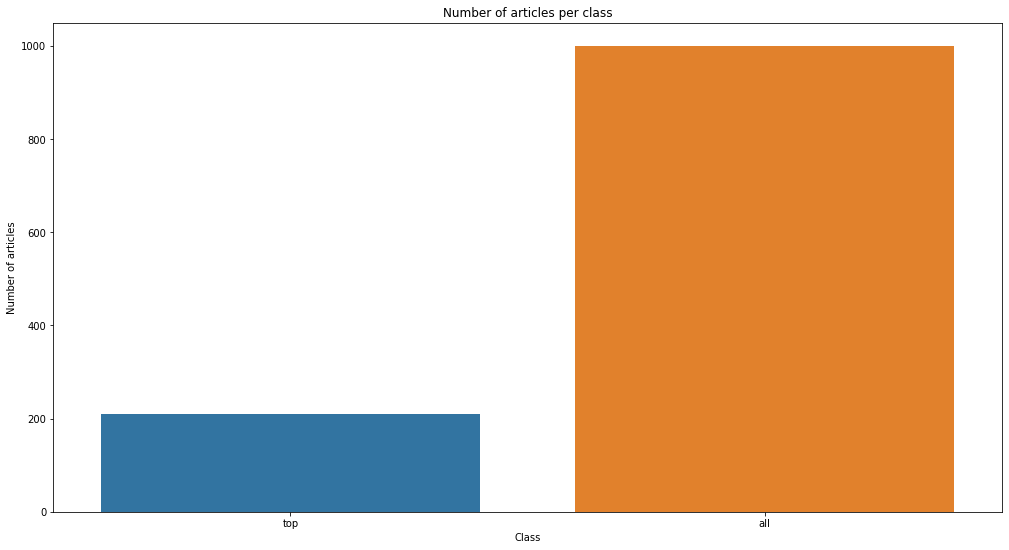

In [15]:
plt.figure(figsize=(17,9))
plt.title('Number of articles per class')
ax = sns.countplot(x='class',data=df)
plt.xlabel('Class')
plt.ylabel('Number of articles')

In [16]:
klasy = {'all':0, 'top':1}
df['class_le'] = df['class'].map(klasy) 

In [17]:
le_byline = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['byline_le'] = le_byline.fit_transform(df['byline'].values.reshape(-1,1))
#print(le_byline.classes_)
le_section = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['section_le'] = le_section.fit_transform(df['section'].values.reshape(-1,1))
#print(le_section.classes_)
le_material = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['type_of_material_le'] = le_material.fit_transform(df['type_of_material'].values.reshape(-1,1))
df['type_of_material_le'] = df['type_of_material_le'].fillna(-2)

In [18]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
nlp=en_core_web_md.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#clean title and abstract, remove stopwords
df['title_clean']=df['title'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
df['abstract_clean']=df['abstract'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

Most common words in titles - class:  0


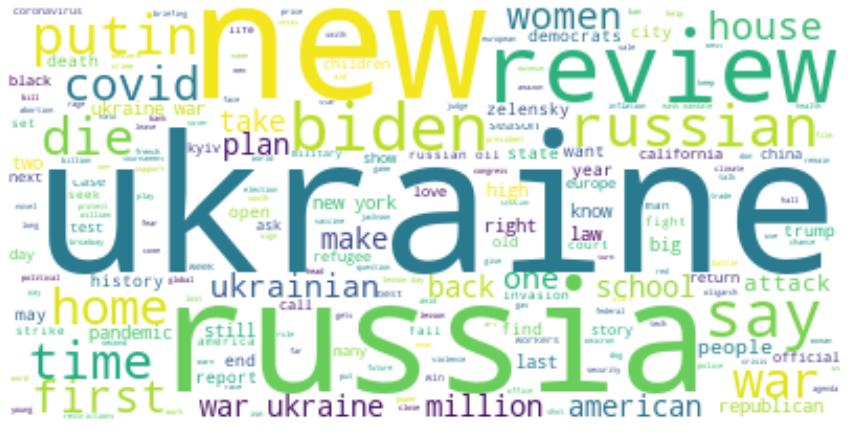

Most common words in titles - class:  1


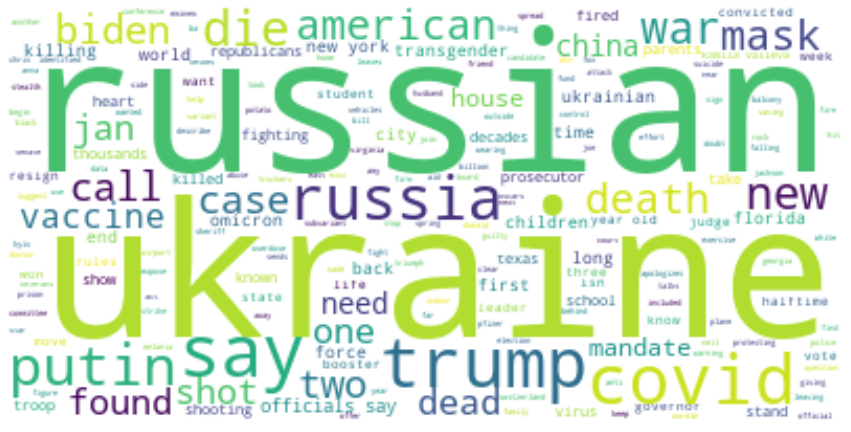

In [20]:
#Generate a word cloud image
l = [0, 1]
for i in l:
    dummy_df = df[df['class_le'] == l[i]]
    print('Most common words in titles - class: ',l[i])
    wordcloud = WordCloud(background_color="white",prefer_horizontal=1,relative_scaling=0.5).generate(' '.join(map(str, dummy_df['title_clean'])))  
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Most common words in abstracts - class:   0


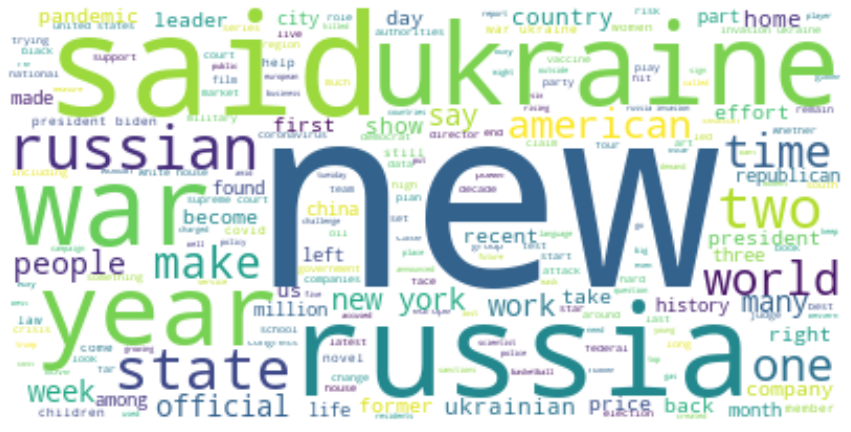

Most common words in abstracts - class:   1


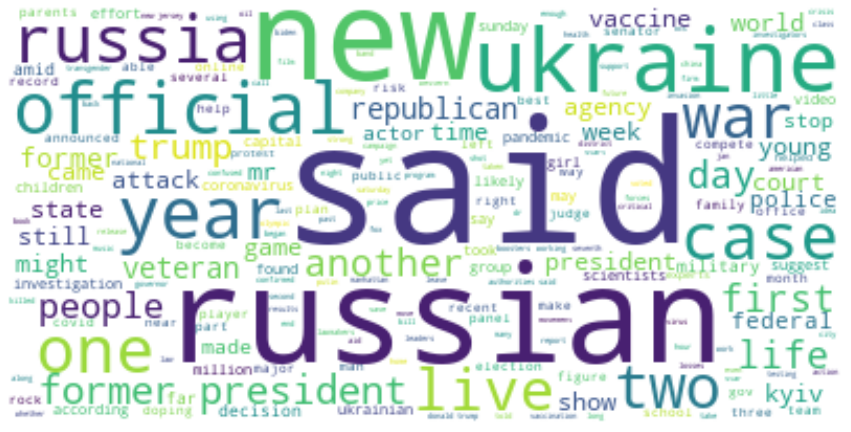

In [21]:
a = [0, 1]
for i in l:
    dummy_df = df[df['class_le'] == a[i]]
    print('Most common words in abstracts - class:  ',a[i])
    wordcloud = WordCloud(background_color="white",prefer_horizontal=1,relative_scaling=0.5).generate(' '.join(map(str, dummy_df['abstract_clean'])))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [22]:
df['title_vec_avg']=df['title_clean'].map(nlp).map(lambda x: np.mean(x.vector))                                                       #the average of the word vectors in the title

In [23]:
df['abstract_vec_avg']=df['abstract_clean'].map(nlp).map(lambda x: np.mean(x.vector))                                                 #the average of the word vectors in the abstract

In [24]:
df['title_len'] = df['title'].apply(lambda x: len(x.split()))                                                                         #number of words in the title (title length)
df['abstract_len'] = df['abstract'].apply(lambda x: len(x.split()))                                                                   #number of words in the abstract (abstract length)
def cap_lett(message):
  n=0
  for x in message:
    if x.isupper():
      n += 1
  return n
df['capital_letters'] = df['title'].apply(cap_lett)                                                                                   #the number of capital letters in the title
df['title_punct_num'] = df['title'].apply(lambda x: len(''.join([word for word in x if word in string.punctuation])))                 #the number of all punctuation marks in the title
df['abstract_punct_num'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word in string.punctuation])))           #the number of all punctuation marks in the abstract
df['title_!'] = df['title'].apply(lambda x: len(''.join([word for word in x if word == "!"])))                                        #number of exclamation marks in the title
df['abstract_!'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word == "!"])))                                  #number of exclamation marks in the abstract
df['title_?'] = df['title'].apply(lambda x: len(''.join([word for word in x if word == "?"])))                                        #number of question marks in the title
df['abstract_?'] = df['abstract'].apply(lambda x: len(''.join([word for word in x if word == "?"])))                                  #number of question marks in the abstract
df['authors_num'] = df['byline'].apply(lambda x: len(''.join([word for word in x if word == "," or word == 'and' or word == '&']))+1) #number of authors
def is_coauthor(authors_num):
  if authors_num > 1: 
    coauthors = 1
  else: 
    coauthors = 0
  return coauthors
df['coauthors'] = df['authors_num'].apply(is_coauthor)                                                                                #whether there is more than 1 author

Text(0.5, 1.0, 'Number of articles per section')

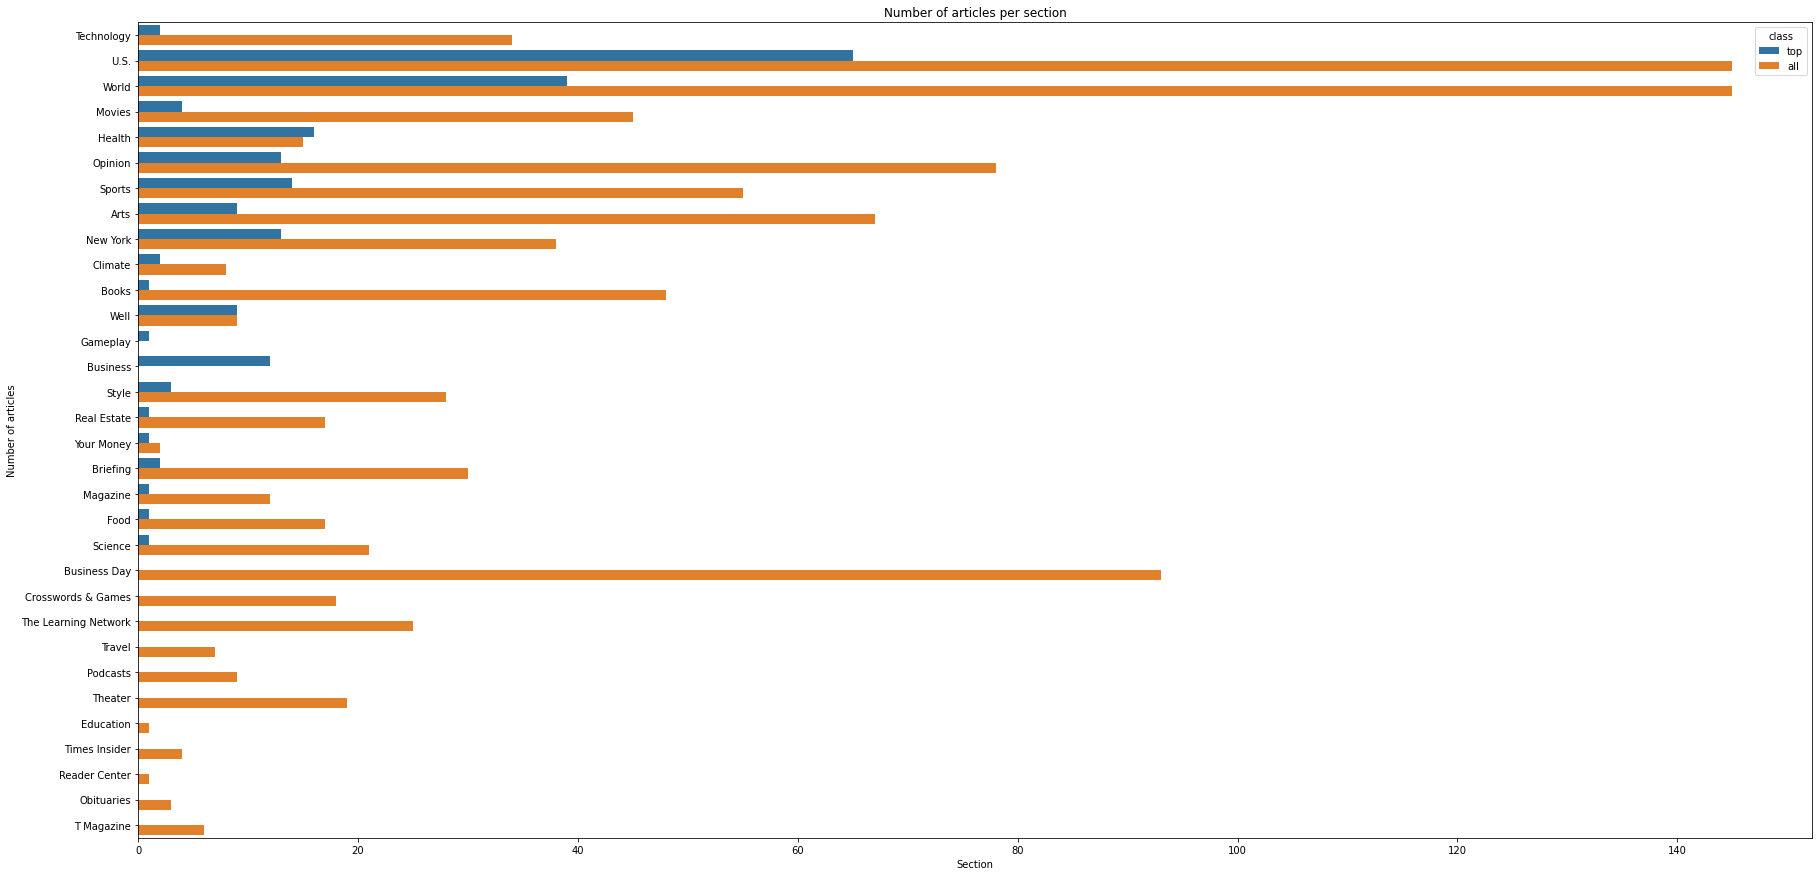

In [25]:
plt.figure(figsize=(30,15))
ax = sns.countplot(y='section', hue='class', data=df)
plt.xlabel('Section')
plt.ylabel('Number of articles')
plt.title('Number of articles per section')

In [26]:
def group_sections(section): 
    if section in ('Sports', 'Books', 'Movies', 'Crosswords & Games', 'Theater', 'Arts'):   #entertainment
      return 1
    elif section in ('Health', 'Style', 'Food', 'Well', 'Travel', 'Fashion & Style', 'Home & Garden', 'T Magazine'): #lifestyle
      return 2 
    elif section in ('Technology', 'Climate', 'Science', 'Education'): #knowlegde
      return 3
    elif section in ('Business', 'You Money', 'Real Estate', 'Business Day', 'Briefing'): #business
      return 4 
    elif section == 'World':
      return 5
    elif section in ('U.S.', 'New York'):
      return 6
    return 7            #others
df['sections_grouped'] = df['section'].map(group_sections) 

In [27]:
ent = df['title'].map(nlp).map(lambda x: x.ents)
df['title_ner'] = ent.map(lambda e: [en.text for en in e])          #NERs in the title

In [28]:
df['title_ner_type'] = ent.map(lambda e: [en.label_ for en in e])   #NER types in the title

In [29]:
df['ners_num'] = df['title_ner_type'].map(lambda x: len(x))         #number of NERs in the title

In [30]:
def ners_GPE(x):
  for i in x:
    if i == 'GPE':
      return 1
    return 0

def ners_PERSON(x):
  for i in x:
    if i == 'PERSON':
      return 1
    return 0

def ners_ORG(x):
  for i in x:
    if i == 'ORG':
      return 1
    return 0

def ners_MONEY(x):
  for i in x:
    if i == 'MONEY':
      return 1
    return 0

def ners_NORP(x):
  for i in x:
    if i == 'NORP':
      return 1
    return 0

In [31]:
df['ner_GPE'] = df['title_ner_type'].map(ners_GPE)
df['ner_PERSON'] = df['title_ner_type'].map(ners_PERSON)
df['ner_ORG'] = df['title_ner_type'].map(ners_ORG)
df['ner_MONEY'] = df['title_ner_type'].map(ners_MONEY)
df['ner_NORP'] = df['title_ner_type'].map(ners_NORP)
df['ner_GPE'] = df['ner_GPE'].fillna(0)
df['ner_PERSON'] = df['ner_PERSON'].fillna(0)
df['ner_ORG'] = df['ner_ORG'].fillna(0)
df['ner_MONEY'] = df['ner_MONEY'].fillna(0)
df['ner_NORP'] = df['ner_NORP'].fillna(0)

In [32]:
df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')           
df['pub_day_of_week'] = df['pub_date'].dt.day_of_week                       #the day of the week on which the article was published

In [33]:
df['pub_day_of_week'] = df['pub_day_of_week'].fillna(-1)

In [34]:
sent = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['title'].apply(lambda x: sent.polarity_scores(x)['compound'])          #title sentiment
df['abstract_sentiment'] = df['abstract'].apply(lambda x: sent.polarity_scores(x)['compound'])    #abstract sentiment

In [35]:
df.sample()

,section,byline,title,abstract,class,print_page,pub_date,type_of_material,class_le,byline_le,...,title_ner_type,ners_num,ner_GPE,ner_PERSON,ner_ORG,ner_MONEY,ner_NORP,pub_day_of_week,title_sentiment,abstract_sentiment
2090,Opinion,Ross Douthat,Will the Ukraine War End the Age of Populism?,Populism’s poor fit for this particular moment...,all,22.0,2022-03-16 09:00:21+00:00,Op-Ed,0,627.0,...,[EVENT],1,0.0,0.0,0.0,0.0,0.0,2.0,-0.5994,-0.4939


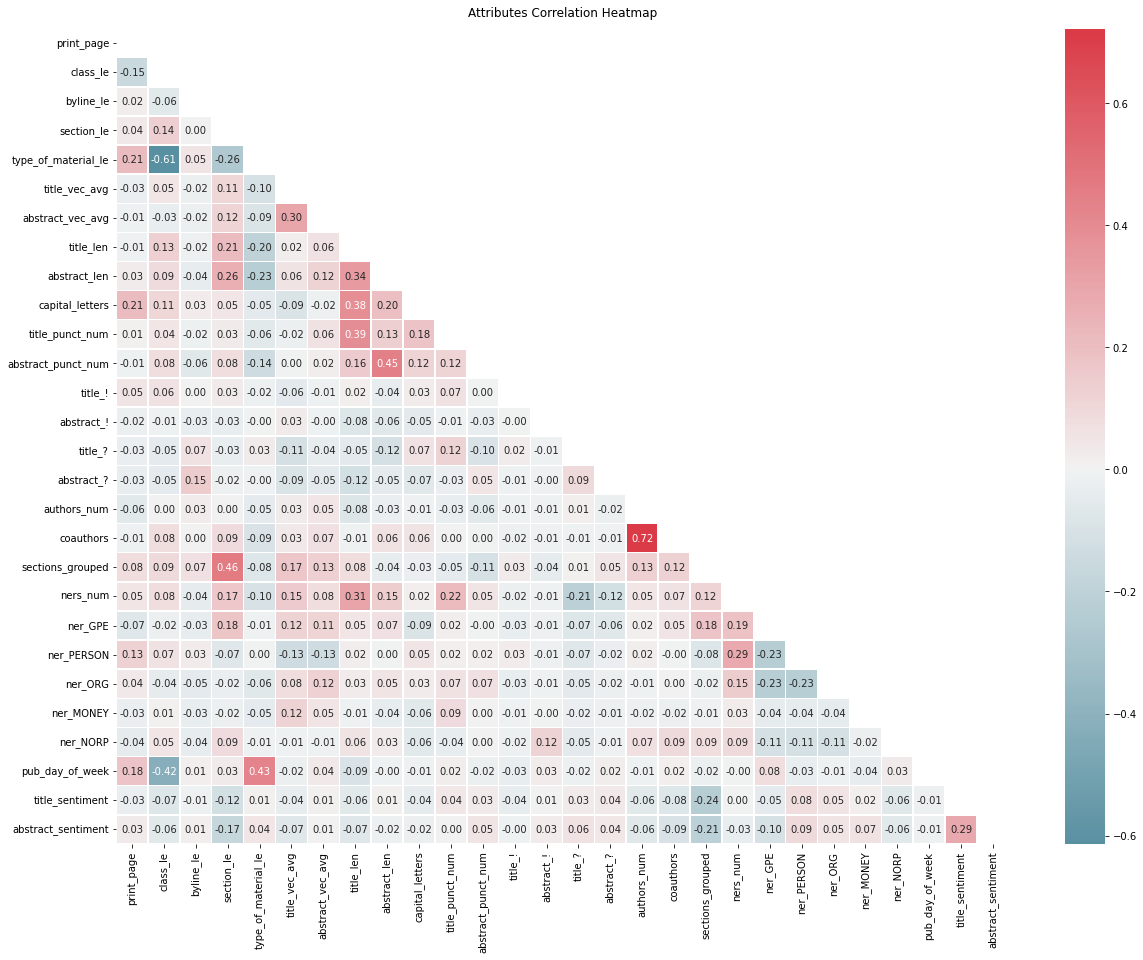

In [36]:
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(df.select_dtypes(np.number).corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(df.select_dtypes(np.number).corr(),
                      annot=True, cmap=cmap, mask=mask, center=0,
                      linewidths=.5, fmt='.2f');
heatmap.set_title('Attributes Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [37]:
def to_1D(series):
    return pd.DataFrame([x for _list in series for x in _list],columns=['country'])

In [38]:
df['countries'] = ent.map(lambda e: [en.text for en in e if en.label_ == "GPE"])

In [39]:
all_countries = to_1D(df['countries'])
all_countries['weight'] = 1

In [40]:
states=['Texas', 'Minneapolis', 'Washington', 'Florida', 'Seattle', 'Oklahoma', 'Utah', 'Georgia', 'New York City Sewage', 'N.J.', 'Pennsylvania',  'New York', 'Los Angeles', 'Ohio','Kentucky', 'Philadelphia',  'Long Island', 'Virginia',
'Wisconsin',  'California', 'Iowa', 'New York City’s', 'Ontario', 'New York City','Oregon', 'Washington State', 'D.C.', 'Indiana', 'Maryland', 'Idaho', 'Brooklyn',  'N.Y.', 'New York’s', 'Connecticut',  'Manhattan', 'Albany', 'Palm Beach',  
'Oakland', 'Buffalo', 'Cleveland','Louisville', 'Rowayton', 'Conn.', 'Jackson','San Francisco', 'Michigan', 'Illinois', 'Hawaii', 'South Carolina','Nevada', 'Westchester', 'Suffolk', 'Alaska', 'Riverhead', 'Colorado', 'Atlanta', 'Missouri', 
'Alabama','Arizona', 'Hollywood','Us','the United States']

US_dict = dict.fromkeys(states, 'U.S.')

countries_dict = {'Ukrainian':'Ukraine','Bucha':'Ukraine', 'Kyiv':'Ukraine', 'Ukraine City Near':'Ukraine', 'Lviv':'Ukraine', 'Mariupol':'Ukraine', 'Donbas':'Ukraine', 
                  'Moscow':'Russia', 'Shanghai':'China', 'Hong Kong':'China', 'Beijing':'China', 'North Korea’s':'North Korea', 'Quebec':'Canada',
                  'Paris':'France', 'Geneva':'Switzerland', 'London':'U.K.', 'Britain':'U.K.'}

In [41]:
all_countries.replace({'country':US_dict}, inplace=True)
all_countries.replace({'country':countries_dict}, inplace=True)

In [42]:
grouped = all_countries.groupby('country').sum() 
grouped = grouped.reset_index()

In [43]:
fig = px.choropleth(grouped, locations='country', locationmode='country names', 
                     color='weight',  projection = 'natural earth',
                     range_color= [0, max(grouped['weight'])], 
                    labels={'weight':'Number of occurrences'},
                     title='Countries covered by the articles')

fig.show()

In [44]:
df.to_csv('./df_for_classification.csv')